# Time Series Anomaly Detection with Machine Learning Models

## Author: Seung Hun Han

## Date: 2023-03-20

The purpose of this notebook is to guide you through the process of TSAD with three different types of machine learning algorithms.

Namely,
### 1. Mean Absolute Deviation

### 2. Isolation Forest

### 3. Local Outlier Factor

Please contant andrewhan@korea.ac.kr for any query.

All comments and feedbacks welcomed :)

We will use 'ambient_temperature_system_failure' data from NAB dataset.

Given dataset contains label in a form of timestamp corresponding to the starting and ending point of observed anomalies.

[['2013-12-15 07:00:00.000000', '2013-12-30 09:00:00.000000'],
 ['2014-03-29 15:00:00.000000', '2014-04-20 22:00:00.000000']]

In the example given above, there had been two sequence of anomalies one of which started at 2013-12-15 07:00:00 and ended at 2013-12-30 09:00:00.
As a result, all data point between anomalous sequence shall be treated as anomalies.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [6]:
df_dir = '/workspace/ambient_temperature_system_failure.csv'
label_dir = '/workspace/combined_windows.json'
label_name = 'realKnownCause/ambient_temperature_system_failure.csv'

In [7]:
def label_anomaly(data_dir , label_dir, label_name): 

    with open(label_dir) as FI:
        j_label = json.load(FI)

    anomaly_label = j_label[label_name]
    anomalous_incidence = len(anomaly_label)
    
    df = pd.read_csv(data_dir)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['anomaly'] = 1
    df['incidence'] = 0
    for idx, incident in enumerate(anomaly_label, start=1):
        df.loc[(df.loc[:,'timestamp']>=incident[0]) & (df.loc[:,'timestamp']<=incident[1]),'anomaly'] = -1
        df.loc[(df.loc[:,'timestamp']>=incident[0]) & (df.loc[:,'timestamp']<=incident[1]),'incidence'] = idx

    return df, anomalous_incidence

In [8]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

def plot_ts(df: pd.DataFrame, anomalous_incidence: int, title: str, method: str = None):

    plt.figure(figsize=(20,10))
    plt.plot(df['timestamp'], 
             df['value'], 
             alpha = 0.8, 
             linewidth = 2,
             color = 'gray',
             label = 'Normal'
             )

    anomaly_label = ''
    for i in range(anomalous_incidence):
        if i ==1:
            anomaly_label ='Ground Truth'
        plt.plot(df.query('anomaly == -1 and incidence == {}'.format(i+1))['timestamp'],
                 df.query('anomaly == -1 and incidence == {}'.format(i+1))['value'], 
                 linewidth = 2,
                 color= 'skyblue',
                 label = anomaly_label 
                 )
        
        plt.text(df.query('anomaly == -1 and incidence == {}'.format(i+1))['timestamp'].median(),
                df.query('anomaly == -1 and incidence == {}'.format(i+1))['value'].max(), 
                f'Incidence {i+1}',
                size = 10
                )
    if method != None:
        plt.scatter(df.query('{}_anomaly == -1'.format(method))['timestamp'],
                 df.query('{}_anomaly == -1'.format(method))['value'], 
                 color ='red',
                 label = 'Predicted Label'
                 )
    
    plt.xticks(rotation = 90)
    plt.title(title, size = 15)
    plt.legend()

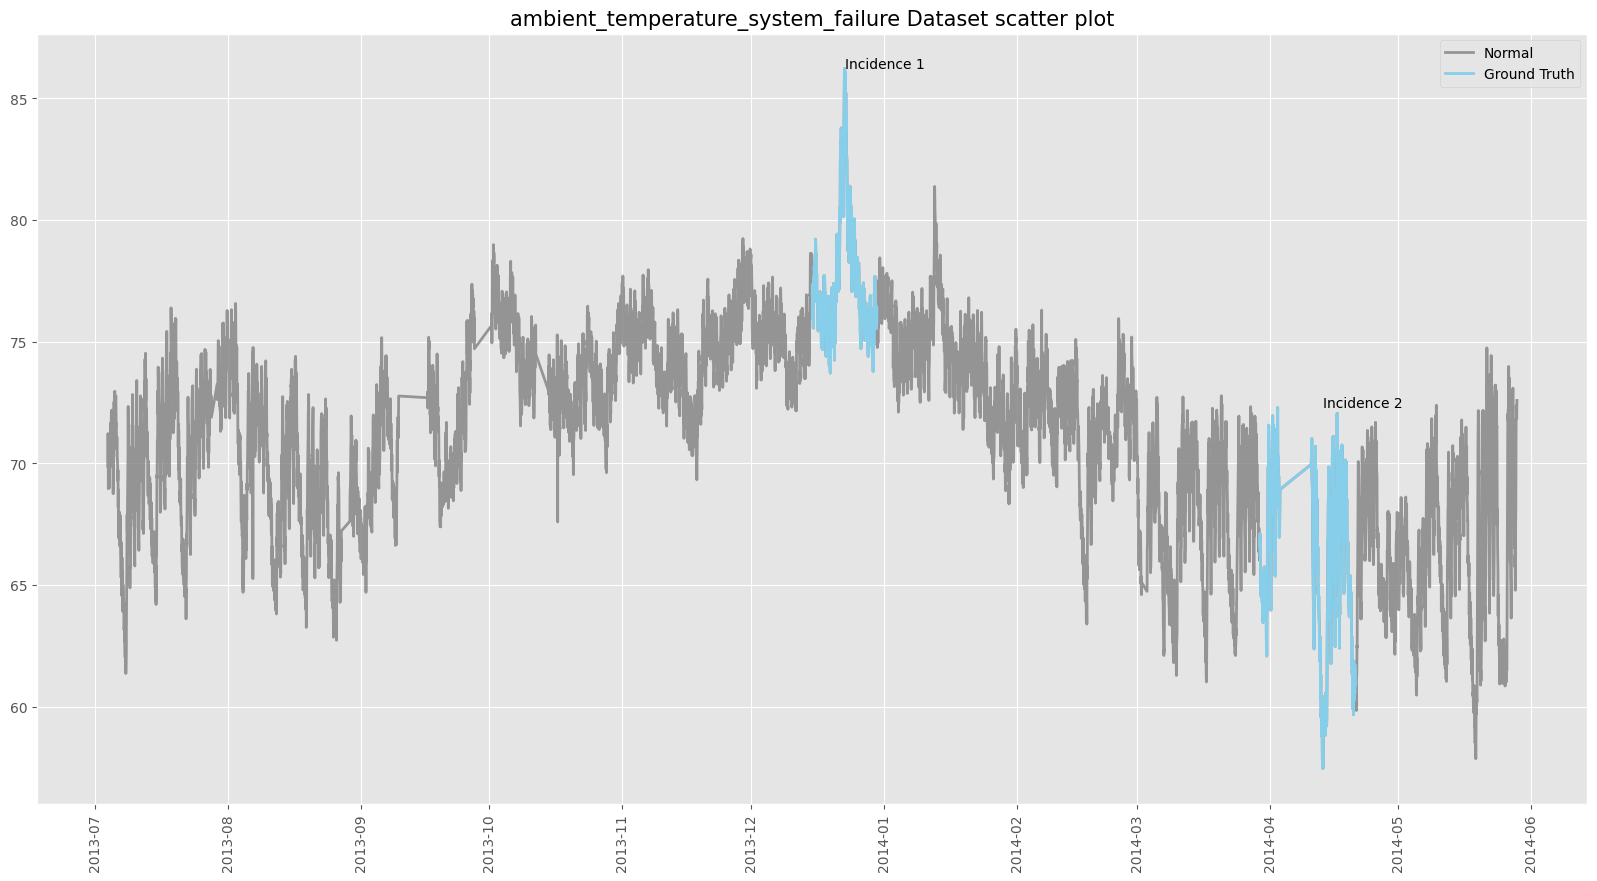

In [9]:
df, anomalous_incidence = label_anomaly(df_dir, label_dir, label_name)

plot_ts(df, anomalous_incidence, 'ambient_temperature_system_failure Dataset scatter plot')

Detecting the first anomalous sequence might not be troublesome as its value distinctively increases compared to adjacent sequences.
Nonetheless, the second anomalous sequence does not quite diverge away from the adjacent sequences. Therefore, contexts nearby the anomalous data point should be adequately taken into account, which could possibly make detecting the second anomalous sequence a hard task.

# Yet

Bare in mind that none of machine learning mechanism, which will be introduced in the following steps, takes temporal context into account. As a result, the quality of anomaly detection using three models is bound to be poor.

## 1. Mean Absolute Deviation (MAD)

Selected method labels data points that diveiate 'significantly' away from the center (mean) as anomalies.

Those who are familar with a statistical modelling should have noticed that such method resembles identifying outlier using the formula mu+-1.5 IQR.

As a result, the key assumption of MAD is that the distribution of a sample data should resemble "Normal Distribution"

Ideally, closer the sample distribution is to normal distribution, better the model will detect anomalies.

In reality, not many sample distribution exactly follow normal distribution. Thus, MAD does not guarantee quality result unless normality assumpotion is completely satisfied.

/tmp/ipykernel_4214/1888462493.py:3: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(np.array(df['value']), bw=0.5) # Distribution is quite skewed to left. Still, it has distinctive bell-shaped curve.


<AxesSubplot: ylabel='Density'>

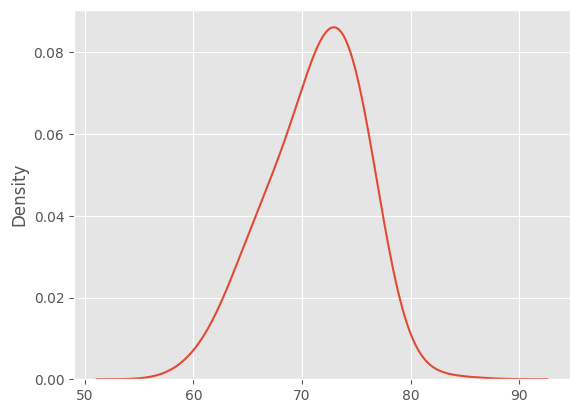

In [10]:
import seaborn as sns

sns.kdeplot(np.array(df['value']), bw=0.5) # Distribution is quite skewed to left. Still, it has distinctive bell-shaped curve.

In [11]:
x = np.array(df['value'])

In [12]:
numerator = 0.6745 * (x-np.median(x))
MAD = np.median(np.abs(x-np.median(x)))

To calculate MAD, either use a formula given above or just use a module provided by scipy.

The result is same either way.

In [13]:
from scipy.stats import median_abs_deviation
median_abs_deviation(x), MAD

(2.9369587900000056, 2.9369587900000056)

In [14]:
def compute_MAD(df):
    x = np.array(df['value'])
    numerator = 0.6745 * (x-np.median(x))
    MAD = np.median(np.abs(x-np.median(x)))
    mad_score = numerator/MAD

    return mad_score

In [15]:
df_mad = df.copy()

In [16]:
df_mad['mad_score']=compute_MAD(df)

In [17]:
df_mad['predicted'] = 1

In [18]:
df_mad.loc[(df_mad['mad_score']>=3.5) | (df_mad['mad_score']<=-3.5),'predicted'] = -1

No data point with ground truth = anomaly has been classified as anomalies.

This is not so much surprising since anomalies in our dataset in general, do not diverge away from the mean as much.

The lesson from this example is that accounting temporal context is paramount in TSAD. 

<AxesSubplot: xlabel='mad_score', ylabel='Density'>

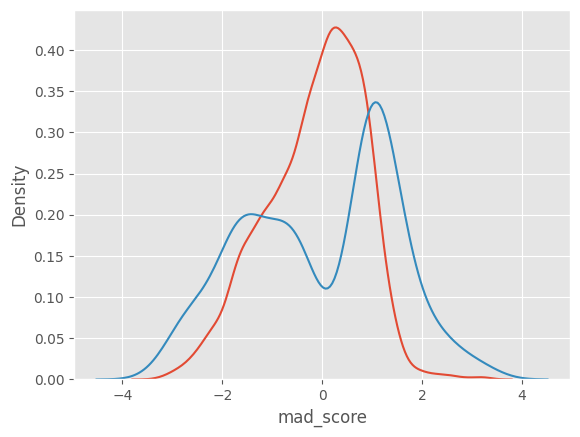

In [19]:
sns.kdeplot(df_mad['mad_score'])
sns.kdeplot(df_mad.query('anomaly == -1')['mad_score']) # Distribution of mad_score for anomalous data point are distributed closely to the center

Text(0.5, 1.0, 'TSAD for ambient_temperature_system_failure Dataset scatter plot')

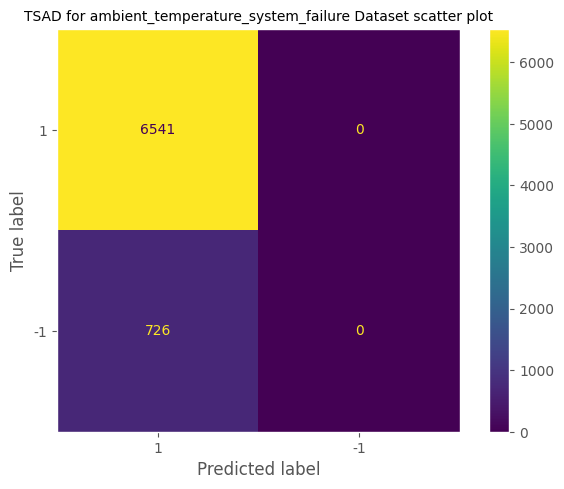

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(df_mad['anomaly'], df_mad['predicted'], labels=[1, -1])
disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])
disp_cm.plot();

plt.grid(False)
plt.tight_layout()
plt.title('TSAD for ambient_temperature_system_failure Dataset scatter plot', size = 10)

## 2. Isolation Forest

As the name indicates, this model is tree-based machine learning algorithm.

As all tree-based models do, Isolation Forest selects an attribute and splits into minimum and maximum section.

For all given data points, Isolation Forests counts attempts required to isolate a data point. 

The intuition is that for an anomalous data point, IF will take small number of attempts for isolation since it will deviates quite far away from other clusters of data points.

### Example of Isolation Forest Normal Data point case
![Normal data point](./img/Normal.webp)

### Example of Isolation Forest Anomalous Data point case
![Anomalous data point](./img/Abnormal.webp)

* Anomalous data point takes less attempts to be isolated!

Now, let's get started

In [21]:
train_x = df.loc[:int(len(df))*0.7]
test_x = df.loc[int(len(df))*0.7:]

In [22]:
contamination = round(len(df.query('anomaly == -1')) / len(df), 5)

In [23]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(random_state=1105)
iso_forest.fit(df['value'].values.reshape(-1,1))

IsolationForest(random_state=1105)

In [24]:
preds_iso_forest = iso_forest.predict(df['value'].values.reshape(-1,1))

Text(0.5, 1.0, 'TSAD for ambient_temperature_system_failure Dataset scatter plot ISO')

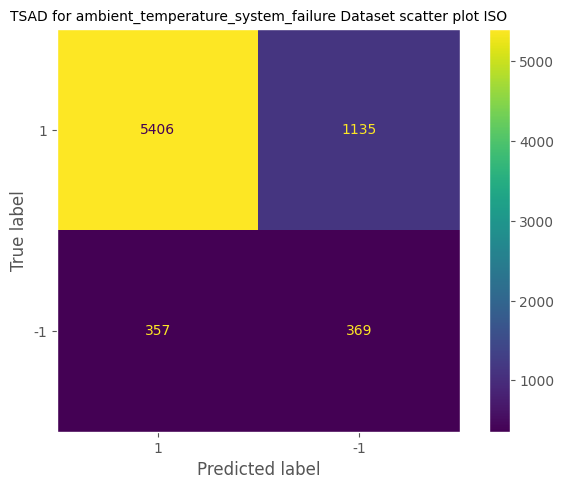

In [25]:
cm = confusion_matrix(df['anomaly'], preds_iso_forest, labels=[1, -1])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

disp_cm.plot();

plt.grid(False)
plt.tight_layout()
plt.title('TSAD for ambient_temperature_system_failure Dataset scatter plot ISO', size = 10)

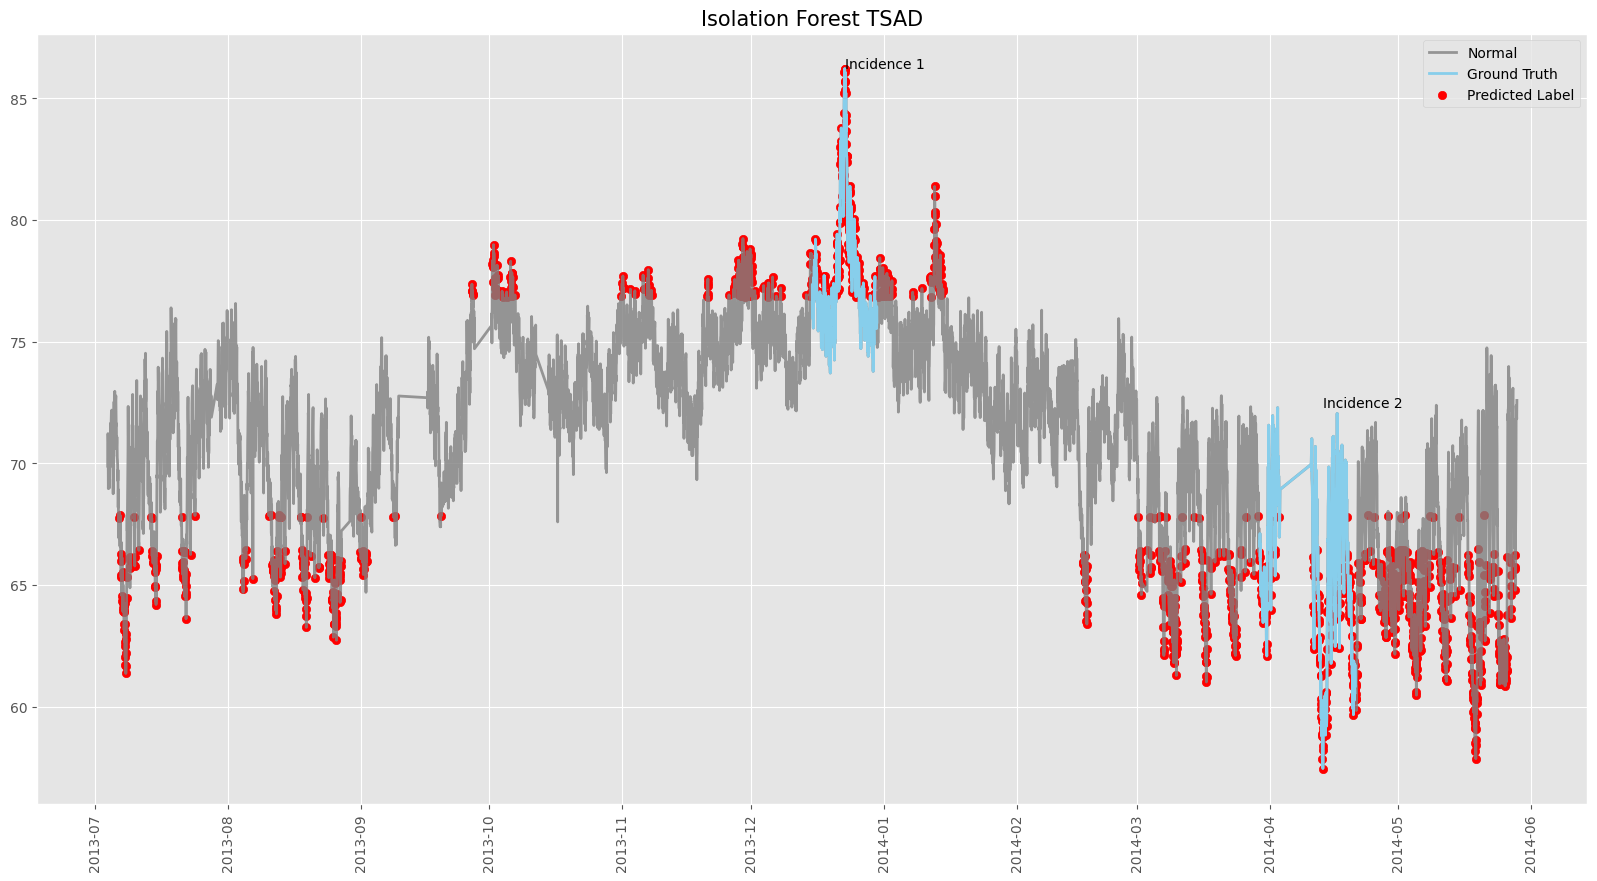

In [26]:
df['IF_anomaly'] = preds_iso_forest
plot_ts(df,anomalous_incidence,'Isolation Forest TSAD','IF')

In [27]:
from sklearn.metrics import recall_score, f1_score, roc_auc_score, precision_score

def return_metrics(y_true, y_pred):

    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)

    print(f'Recall:{recall: .4f} F1:{f1: .4f} AUROC:{roc: .4f} Precision:{precision: .4f}')

    return recall, f1, roc, precision


return_metrics(df['anomaly'], preds_iso_forest)

Recall: 0.8265 F1: 0.8787 AUROC: 0.6674 Precision: 0.9381


(0.8264791316312491, 0.878738621586476, 0.6673717972205832, 0.9380530973451328)

## Implementing Sliding Window

Perhaps treating each time step as an individual data point is not an optimal option.

To partially add temporal context to the model, I will preprocess the data using sliding window.

In [45]:
(df['anomaly']==-1).any()

True

In [46]:
def roll(df: pd.DataFrame, window_size:int, step_size: int):

    seq_len = (len(df)-window_size)//step_size +1

    window_data = np.zeros((seq_len, window_size))
    window_label = np.zeros((seq_len, ))

    idx = 0
    seq_idx = 0

    while(idx < df['value'].values.shape[0] - window_size + 1):
        window_data[seq_idx] = df['value'].values[idx:idx+window_size]
        window_label[seq_idx] = -1 if (df['anomaly'][idx:idx+window_size]==-1).any() else 1
        idx += step_size
        seq_idx +=1
    
    return window_data, window_label

window_data, window_label = roll(df, 60, 60)

In [50]:
iso_forest = IsolationForest(random_state=1105)

iso_forest.fit(window_data.mean(axis=1).reshape(-1,1))

IsolationForest(random_state=1105)

Text(0.5, 1.0, 'TSAD for ambient_temperature_system_failure Dataset scatter plot ISO windowed')

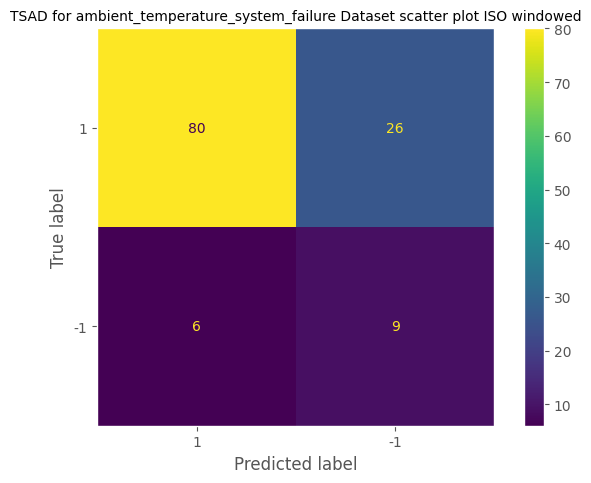

In [51]:
preds_iso = iso_forest.predict(window_data.mean(axis=1).reshape(-1,1))

cm = confusion_matrix(window_label, preds_iso, labels=[1, -1])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

disp_cm.plot();
plt.grid(False)
plt.tight_layout()
plt.title('TSAD for ambient_temperature_system_failure Dataset scatter plot ISO windowed', size = 10)

In [52]:
return_metrics(window_label, preds_iso)

Recall: 0.7547 F1: 0.8333 AUROC: 0.6774 Precision: 0.9302


(0.7547169811320755,
 0.8333333333333334,
 0.6773584905660377,
 0.9302325581395349)

Again, the result is very poor. With Isolation Forest, all the data points were predicted as anomalies.

Such false positive is troublesome since in real life as it leads to unnecessary waste of resources.

## 3. Local Outlier Factors (LOF)

LOF seeks for a data point that are not as close to its nearest neighbors.

The intuition is that distance to nearest neighbors for anomalous data points will be relatively bigger than distance to nearest neighbors for nearest neighbors of anomalous data points.

The description given above might be hard to digest. So let's take a look into an example.

### Example of Isolation Forest Anomalous Data point case
![LOF Example](./img/LOF_example.png)

* For an anomalous data point, it is not as close to its nearest neighbors as its neighbors are close to their own nearest neighbors.

In [53]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=18,contamination=contamination, novelty=True)

lof.fit(df['value'].values.reshape(-1,1))

LocalOutlierFactor(contamination=0.0999, n_neighbors=18, novelty=True)

Text(0.5, 1.0, 'TSAD for ambient_temperature_system_failure Dataset scatter plot LOF')

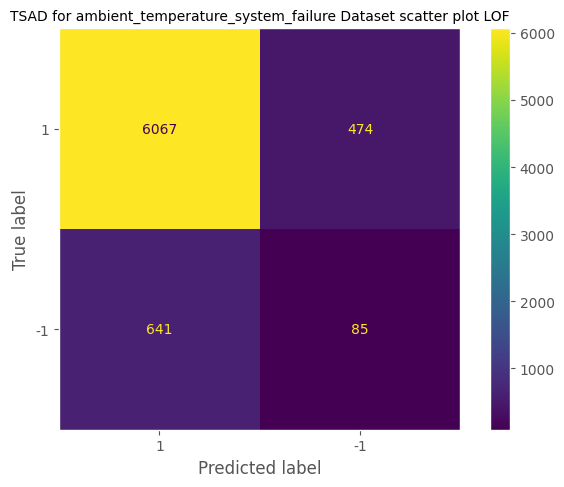

In [54]:
preds_lof = lof.predict(df['value'].values.reshape(-1,1))

cm = confusion_matrix(df['anomaly'], preds_lof, labels=[1, -1])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

disp_cm.plot();
plt.grid(False)
plt.tight_layout()
plt.title('TSAD for ambient_temperature_system_failure Dataset scatter plot LOF', size = 10)


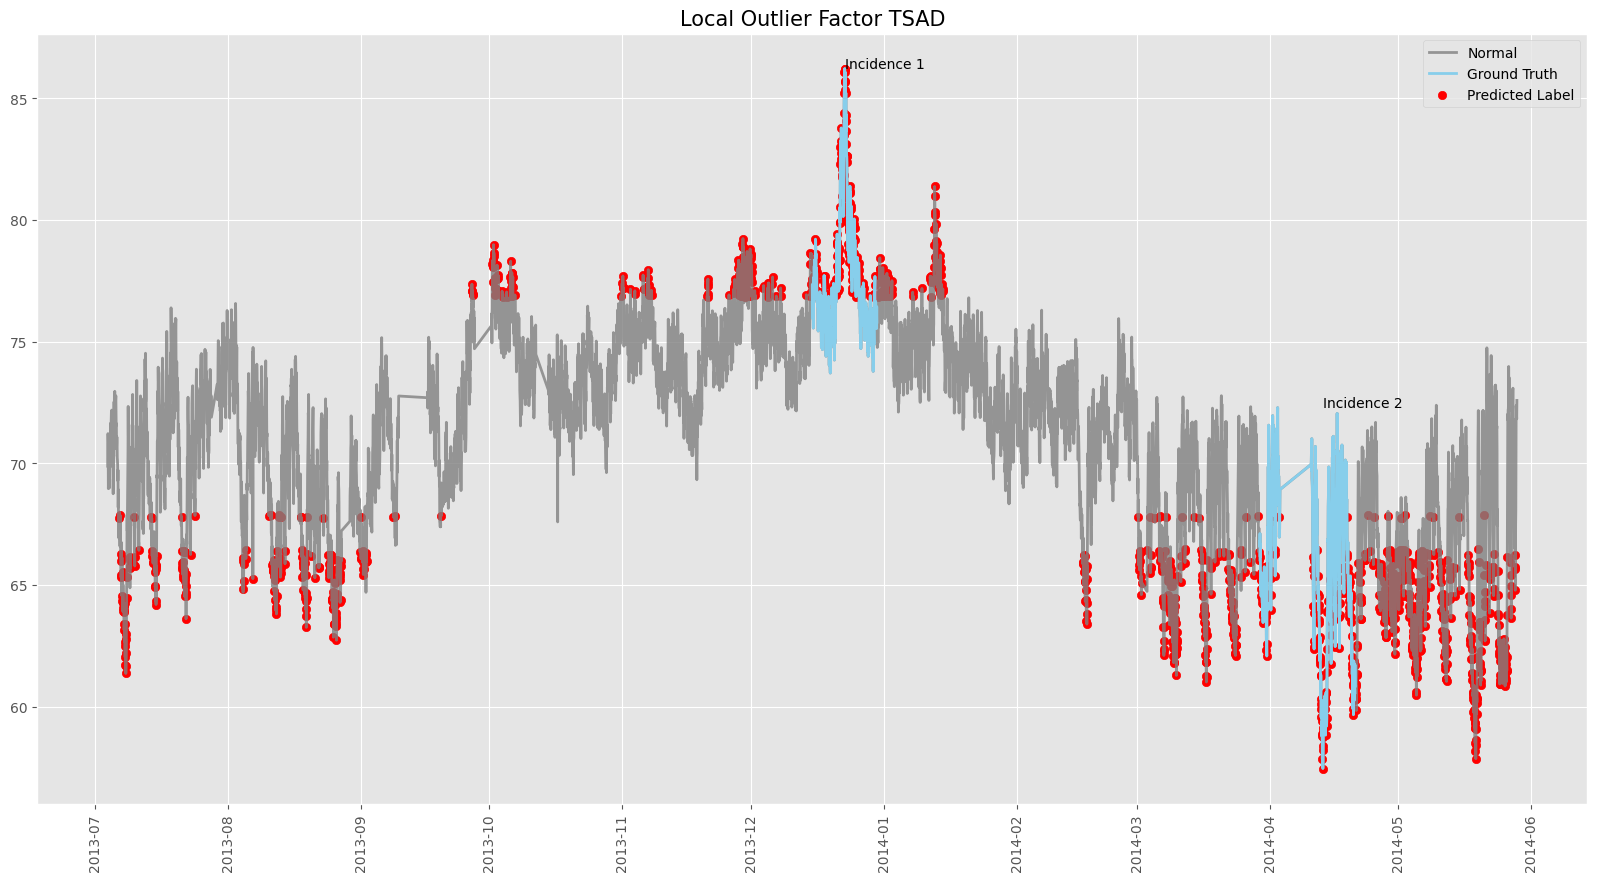

In [55]:
df['LOF_anomaly'] = preds_iso_forest
plot_ts(df,anomalous_incidence,'Local Outlier Factor TSAD','LOF')

In [56]:
return_metrics(df['anomaly'], preds_lof)

Recall: 0.9275 F1: 0.9158 AUROC: 0.5223 Precision: 0.9044


(0.9275340162054732,
 0.9158427051098197,
 0.5223069530063178,
 0.9044424567680381)

In [57]:
from sklearn.metrics import cohen_kappa_score

cohen_kappa_score(df['anomaly'], preds_lof)

0.0496951419392907

In [58]:
lof_window = LocalOutlierFactor(n_neighbors=18,contamination=contamination, novelty=True)

lof.fit(window_data.mean(axis=1).reshape(-1,1))

LocalOutlierFactor(contamination=0.0999, n_neighbors=18, novelty=True)

Text(0.5, 1.0, 'TSAD for ambient_temperature_system_failure Dataset scatter plot LOF windowed')

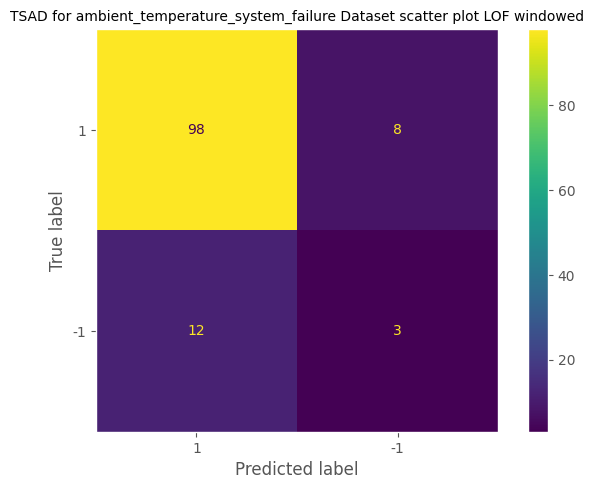

In [59]:
preds_lof = lof.predict(window_data.mean(axis=1).reshape(-1,1))

cm = confusion_matrix(window_label, preds_lof, labels=[1, -1])

disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])

disp_cm.plot();
plt.grid(False)
plt.tight_layout()
plt.title('TSAD for ambient_temperature_system_failure Dataset scatter plot LOF windowed', size = 10)


In [60]:
return_metrics(window_label, preds_lof)

Recall: 0.9245 F1: 0.9074 AUROC: 0.5623 Precision: 0.8909


(0.9245283018867925,
 0.9074074074074073,
 0.5622641509433962,
 0.8909090909090909)